We build a 2D grid from `(0,0)` to `(199,199)` , add the given rectangular obstacles, implements Dijkstra and A* then report costs and expanded nodes, and visualize the resulting paths.

**Obstacles (inclusive coordinates)**:
- (40, 40) to (70, 70)
- (90, 120) to (130, 160)
- (150, 50) to (180, 90)
- (60, 150) to (100, 190)

**Movement**: 8 directions — orthogonal cost = 1, diagonal cost = √2

**Note**:
 If we allow diagonal moves that cut corners (i.e. either adjacent orthogonal cells are filled still to move diagonally), then we get cost of the path to be 299.59 

 If we donot allow daigonal moves that cut corners, then we get the cost of the path to be 300.17 

In [23]:
import heapq
import math
import time
from typing import Tuple, List, Dict, Optional, Set
import numpy as np
import matplotlib.pyplot as plt

Point = Tuple[int, int]
SQRT2 = math.sqrt(2.0)

class Grid:
    def __init__(self, min_coord=0, max_coord=200):
        self.min_x = min_coord
        self.min_y = min_coord
        self.max_x = max_coord
        self.max_y = max_coord
        self.blocked: Set[Point] = set()

    def in_bounds(self, p: Point) -> bool:
        x, y = p
        return self.min_x <= x <= self.max_x and self.min_y <= y <= self.max_y

    def is_free(self, p: Point) -> bool:
        return p not in self.blocked

    def add_block_rect(self, x1:int, y1:int, x2:int, y2:int):
        for x in range(x1, x2+1):
            for y in range(y1, y2+1):
                if self.in_bounds((x,y)):
                    self.blocked.add((x,y))

    def neighbors(self, p: Point):
        x, y = p
        for dx in (-1, 0, 1):
            for dy in (-1, 0, 1):
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x + dx, y + dy
                npnt = (nx, ny)
                if not self.in_bounds(npnt):
                    continue
                if not self.is_free(npnt):
                    continue
                if abs(dx) == 1 and abs(dy) == 1:
                    # prevent corner cutting
                    if not (self.is_free((x+dx, y)) and self.is_free((x, y+dy))):
                        continue
                    cost = SQRT2
                else:
                    cost = 1.0
                yield npnt, cost


# Helpers for pathfinding algorithms
def reconstruct_path(prev: Dict[Point, Optional[Point]], start: Point, goal: Point) -> List[Point]:
    if goal not in prev:
        return []
    path = []
    cur = goal
    while cur is not None:
        path.append(cur)
        cur = prev.get(cur)
    path.reverse()
    if path and path[0] == start:
        return path
    return []


def compute_path_length(path: List[Point]) -> float:
    if not path or len(path) == 1:
        return 0.0
    total = 0.0
    for i in range(len(path)-1):
        x1,y1 = path[i]
        x2,y2 = path[i+1]
        if x1 == x2 or y1 == y2:
            total += 1.0
        else:
            total += SQRT2
    return total

In [24]:
def dijkstra(grid: Grid, start: Point, goal: Point) -> Dict:
    t0 = time.time()
    dist: Dict[Point, float] = {start: 0.0}
    prev: Dict[Point, Optional[Point]] = {start: None}
    visited: Set[Point] = set()
    expanded = 0
    pq = [(0.0, start)]

    while pq:
        d, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        expanded += 1
        if u == goal:
            break
        for v, w in grid.neighbors(u):
            nd = d + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    t1 = time.time()
    path = reconstruct_path(prev, start, goal)
    total_cost = dist.get(goal, math.inf)
    return {
        "path": path,
        "cost": total_cost,
        "expanded": expanded,
        "time_s": t1 - t0
    }


def octile_heuristic(a: Point, b: Point) -> float:
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    dmin = min(dx, dy)
    dmax = max(dx, dy)
    return dmin * SQRT2 + (dmax - dmin) * 1.0


def a_star(grid: Grid, start: Point, goal: Point, heuristic=octile_heuristic) -> Dict:
    t0 = time.time()
    gscore: Dict[Point, float] = {start: 0.0}
    fscore: Dict[Point, float] = {start: heuristic(start, goal)}
    prev: Dict[Point, Optional[Point]] = {start: None}
    open_set = [(fscore[start], start)]
    open_entries = {start}
    closed: Set[Point] = set()
    expanded = 0

    while open_set:
        f, current = heapq.heappop(open_set)
        if current in closed:
            continue
        open_entries.discard(current)
        closed.add(current)
        expanded += 1
        if current == goal:
            break
        for neighbor, cost in grid.neighbors(current):
            tentative_g = gscore[current] + cost
            if neighbor in closed and tentative_g >= gscore.get(neighbor, math.inf):
                continue
            if tentative_g < gscore.get(neighbor, math.inf):
                prev[neighbor] = current
                gscore[neighbor] = tentative_g
                fscore[neighbor] = tentative_g + heuristic(neighbor, goal)
                if neighbor not in open_entries:
                    heapq.heappush(open_set, (fscore[neighbor], neighbor))
                    open_entries.add(neighbor)

    t1 = time.time()
    path = reconstruct_path(prev, start, goal)
    total_cost = gscore.get(goal, math.inf)
    return {
        "path": path,
        "cost": total_cost,
        "expanded": expanded,
        "time_s": t1 - t0
    }

Dijkstra: expanded nodes = 34527, cost = 300.173665, time = 0.189s
Dijkstra: path length (nodes) = 232 
A*: expanded nodes = 7572, cost = 300.173665, time = 0.055s
A*: path length (nodes) = 232 

Verification:
 Dijkstra path cost sum = 300.173665
 A* path cost sum      = 300.173665

Comparison:
 Path cost: Dijkstra = 300.173665, A* = 300.173665
 Expanded nodes: Dijkstra = 34527, A* = 7572
 Time: Dijkstra = 0.189s, A* = 0.055s


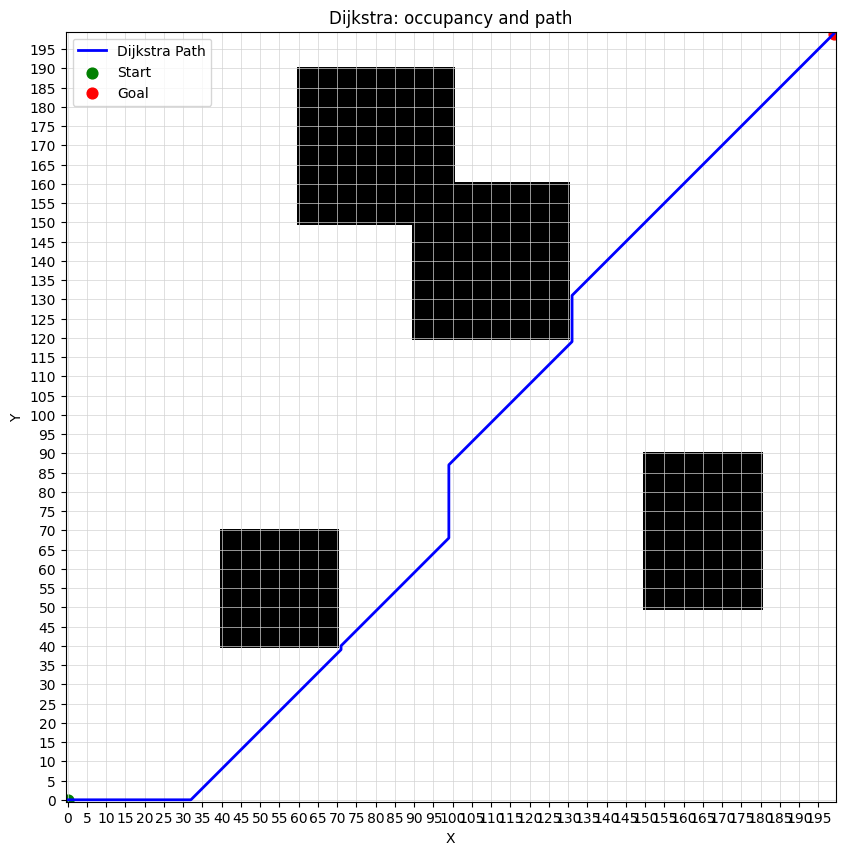

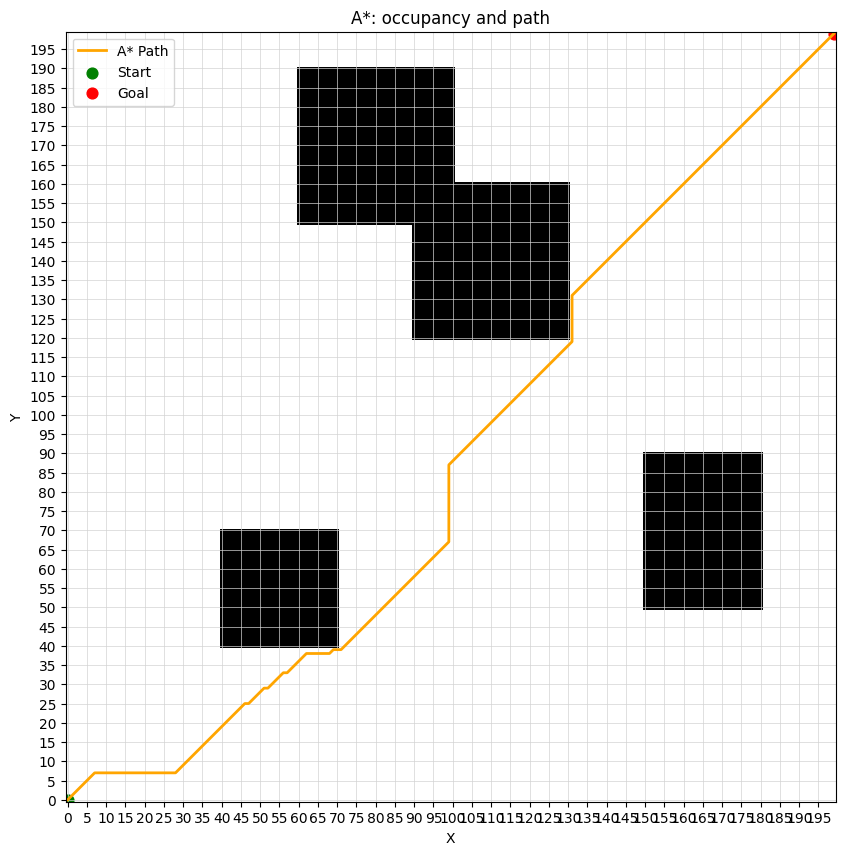

In [ ]:
grid = Grid(min_coord=0, max_coord=199)

grid.add_block_rect(40, 40, 70, 70)
grid.add_block_rect(90, 120, 130, 160)
grid.add_block_rect(150, 50, 180, 90)
grid.add_block_rect(60, 150, 100, 190)

start = (0, 0)
goal = (199, 199)

res_dij = dijkstra(grid, start, goal)
print(f"Dijkstra: expanded nodes = {res_dij['expanded']}, cost = {res_dij['cost']:.6f}, time = {res_dij['time_s']:.3f}s")
print(f"Dijkstra: path length (nodes) = {len(res_dij['path'])} ")

res_astar = a_star(grid, start, goal, heuristic=octile_heuristic)
print(f"A*: expanded nodes = {res_astar['expanded']}, cost = {res_astar['cost']:.6f}, time = {res_astar['time_s']:.3f}s")
print(f"A*: path length (nodes) = {len(res_astar['path'])} ")

# verify computed path costs by summing step costs
actual_cost_dij = compute_path_length(res_dij['path'])
actual_cost_astar = compute_path_length(res_astar['path'])
print("\nVerification:")
print(f" Dijkstra path cost sum = {actual_cost_dij:.6f}")
print(f" A* path cost sum      = {actual_cost_astar:.6f}")

print('\nComparison:')
print(f" Path cost: Dijkstra = {res_dij['cost']:.6f}, A* = {res_astar['cost']:.6f}")
print(f" Expanded nodes: Dijkstra = {res_dij['expanded']}, A* = {res_astar['expanded']}")
print(f" Time: Dijkstra = {res_dij['time_s']:.3f}s, A* = {res_astar['time_s']:.3f}s")

# Prepare occupancy grid for plotting
size_x = grid.max_x - grid.min_x + 1
size_y = grid.max_y - grid.min_y + 1
occ = np.zeros((size_y, size_x), dtype=int)  
for (bx, by) in grid.blocked:
    occ[by - grid.min_y, bx - grid.min_x] = 1

# Helper to convert path to arrays
def path_to_xy(path):
    if not path:
        return [], []
    xs = [p[0] for p in path]
    ys = [p[1] for p in path]
    return xs, ys

# Plot Dijkstra result with higher resolution and grid lines
plt.figure(figsize=(10,10))
plt.imshow(occ, origin='lower', cmap='Greys', interpolation='none')
dxs, dys = path_to_xy(res_dij['path'])
if dxs:
    plt.plot(dxs, dys, color='blue', linewidth=2, label='Dijkstra Path')
plt.scatter([start[0]], [start[1]], color='green', s=60, label='Start')
plt.scatter([goal[0]], [goal[1]], color='red', s=60, label='Goal')
plt.title('Dijkstra: occupancy and path')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.5, size_x-0.5)
plt.ylim(-0.5, size_y-0.5)
plt.grid(which='both', color='lightgray', linewidth=0.5)
plt.xticks(np.arange(0, size_x, 5))
plt.yticks(np.arange(0, size_y, 5))
plt.legend()
plt.show()

# Plot A* result with higher resolution and grid lines
plt.figure(figsize=(10,10))
plt.imshow(occ, origin='lower', cmap='Greys', interpolation='none')
axs, ays = path_to_xy(res_astar['path'])
if axs:
    plt.plot(axs, ays, color='orange', linewidth=2, label='A* Path')
plt.scatter([start[0]], [start[1]], color='green', s=60, label='Start')
plt.scatter([goal[0]], [goal[1]], color='red', s=60, label='Goal')
plt.title("A*: occupancy and path")
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-0.5, size_x-0.5)
plt.ylim(-0.5, size_y-0.5)
plt.grid(which='both', color='lightgray', linewidth=0.5)
plt.xticks(np.arange(0, size_x, 5))
plt.yticks(np.arange(0, size_y, 5))
plt.legend()
plt.show()
